## The environment

The environment is a NxN array of integers. 
Each cell of this environment can have the following values:
- 0 : empty cell
- 1 : obstacle, non-traversable
- 2 : lava
- 3 : exit

All border cells are obstacles.
Upon initialization, the environment has:
- N/2 obstacles placed randomly in the maze.
- N/2 lava cells placed randomly in the cell.

## The game

The agent starts in a random empty cell, and has to reach the exit.
The exit is randomly positioned in an other empty cell.

At each timestep:
- the agent decides on an action (move up, left, right or down)
- the action is sent to the environment
- the environment sends back observations, rewards and a boolean that indicates whether the environment terminated.

The environment terminates if the agent reaches the exit, or if the environement reaches a time limit of N^2 timesteps.

## Observations

The agent receives a dictionary of observations:
- target: relative coordinates of the exit 
- proximity: a 3x3 array that encodes for the value of the cells around the agent.

## Rewards

When acting, an agent receives a reward depending on the cell it ends up on:
- if the agent moves towards an obstacle, it gets a reward of -5 and stays at its original position
- if the agent is on a lava cell after its action, it receives a reward of -20
- at each timestep, the agent receives an additional reward of -1
- when the agent reaches the goal, it receives a reward of N**2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [61]:
class Dungeon:
    
    def __init__(self, N):
        
        # Numpy array that holds the information about the environment
        self.dungeon = np.zeros([int(N),int(N)])
        self.N = N
        # position of the agent and exit will be decided by resetting the environment.
        self.position_agent = None
        self.position_exit = None
        #position of obstacles randomly generated. Create an array with 5 rows and 2 columns to represent the coordinates of each obstacle
        self.position_obstacles = np.random.randint(1,self.N-1, size=(self.N//2, 2))
        for x,y in enumerate(self.position_obstacles):
          self.dungeon[y[0]][y[1]] = 1
        
        self.dungeon[0,:] = 1
        self.dungeon[N-1,:] = 1
        self.dungeon[:, 0] = 1
        self.dungeon[:, N-1] = 1

        #position of lava randomly generated. Create an array with 5 rows and 2 columns to represent the coordinates of lava. These should have no overlap with obstacles. These 2 arrays will be used to add relevant numbers to dungeon array
        self.position_lava = np.random.randint(1,self.N-1, size=(self.N//2, 2))
        for x,y in enumerate(self.position_lava):
          self.dungeon[y[0]][y[1]] = 2
        
        
        # run time
        self.time_elapsed = 0
        self.time_limit = N**2
        
        reward = 0


    def step(self, action):
        
        # action is 'up', 'down', 'left', or 'right'
        if action == 'up': 
          action = np.array([[-1],[0]])
        elif action == 'down':
          action = np.array([[1],[0]])
        elif action == 'left':
          action = np.array([[0],[-1]])
        elif action == 'right':
          action = np.array([[0],[1]])

        # modify the position of the agent. Add the movement array to the position of the agent. if the cell it moves to is obstacle, don't allow movement and -5 from reward. If lava then just -20 from reward but allow movement. If at exit then +N**2 to reward.

        #print(self.position_agent)
        #print(action)

        position_agent_new = (self.position_agent + action)
        global reward
        if self.time_elapsed == 0:
          reward = 0
        if self.dungeon[position_agent_new[0], [position_agent_new[1]]] == 1: 
          position_agent_new = self.position_agent
          r = -5
        elif self.dungeon[position_agent_new[0], [position_agent_new[1]]] == 2:
          self.position_agent = position_agent_new 
          r = -20
        elif self.dungeon[position_agent_new[0], [position_agent_new[1]]] == 3:
          self.position_agent = position_agent_new 
          r = +100
        else: 
          self.position_agent = position_agent_new 
          r = 0




        # calculate total reward. -1 each time for time-step

        reward = reward + r -1
        print(reward)

        # calculate observations. Need to create a dictionary containing the target coordinates (position_exit) and the surrounding 12 cells with agent central (will probably have to slice the dungeon array)

        #observations = self.dungeon
        #observations[self.position_agent[0], self.position_agent[1]] = 5
        xmin = int((self.position_agent[0])-1)
        xmax = int((self.position_agent[0])+2)
        ymin = int((self.position_agent[1])-1)
        ymax = int(self.position_agent[1]+2)
        #print('xmax=', xmax)
        #print('xmin=', xmin)
        #print('ymax', ymax)
        #print('ymin', ymin)
        #self.dungeon[self.position_agent[0],self.position_agent[1]] = 5
        pov = self.dungeon[xmin:xmax,ymin:ymax]
        observations = {'target': self.position_exit-self.position_agent, 'proximity': pov}
        print(observations)

        # add time step
        self.time_elapsed = self.time_elapsed+1
        
        # verify termination condition
        if self.dungeon[self.position_agent[0],self.position_agent[1]] == 3:
          done = 1
        elif self.time_elapsed == self.time_limit:
          done = 1
        else: 
          done = 0
        
        return observations, reward, done
    



    def display(self):
        
        print(self.dungeon)
        
        



    def reset(self):
        """
        This function resets the environment to its original state (time = 0).
        Then it places the agent and exit at new random locations.
        
        It is common practice to return the observations, 
        so that the agent can decide on the first action right after the resetting of the environment.
        
        """

        self.time_elapsed = 0
        reward = 0
        # position of the agent is a numpy array

        self.position_agent = np.random.randint(1,self.N-1, size=(2, 1))
        
        # position of the exit is a numpy array

        self.position_exit = np.random.randint(self.N, size=(2, 1))-1
        self.dungeon[self.position_exit[0],self.position_exit[1]] = 3


        # Calculate observations
        xmin = int((self.position_agent[0])-1)
        xmax = int((self.position_agent[0])+2)
        ymin = int((self.position_agent[1])-1)
        ymax = int(self.position_agent[1]+2)
        #print('xmax=', xmax)
        #print('xmin=', xmin)
        #print('ymax', ymax)
        #print('ymin', ymin)
        self.dungeon[self.position_agent[0],self.position_agent[1]] = 5
        tar = self.position_exit-self.position_agent
        pov = self.dungeon[xmin:xmax,ymin:ymax]
        observations = {'target': tar, 'proximity': pov}
        print(observations)
        #observations[self.position_exit[0],self.position_exit[1]] = 2

        return observations

In [62]:
dungeon = Dungeon(15)
obs = dungeon.reset()

#print(dungeon.position_agent)
dungeon.display()
#obs, reward, done = dungeon.step('left')
#print(reward)
print(dungeon.time_elapsed)
print('position =', dungeon.position_agent)
#dungeon.display()

{'target': array([[-5],
       [-8]]), 'proximity': array([[0., 0., 1.],
       [0., 5., 1.],
       [0., 0., 1.]])}
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 1.]
 [1. 0. 0. 0. 0. 0. 2. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
0
position = [[ 4]
 [13]]


In [63]:
def basic_policy(observation):

    obs_up = observation['proximity'][0][1]
    obs_down = observation['proximity'][2][1]
    obs_left = observation['proximity'][1][0]
    obs_right = observation['proximity'][1][2]    
    dir = ['up', 'down', 'left','right']

    if obs_up == 3:
      return 'up'
    if obs_down == 3:
      return 'down'
    if obs_left == 3: 
      return 'left'
    if obs_right == 3:
      return 'right' 
    
    if obs_up == 1:
      dir.remove('up')
    if obs_down == 1:
      dir.remove('down')
    if obs_left == 1:
      dir.remove('left')
    if obs_right == 1:
      dir.remove('right')
    
    if obs_up == 0 or obs_down == 0 or obs_right == 0 or obs_left == 0:
      if obs_up == 2:
        dir.remove('up')
      if obs_down == 2:
        dir.remove('down')
      if obs_left == 2:
        dir.remove('left')
      if obs_right == 2:
        dir.remove('right')
    
    val = random.randrange(len(dir))
    action = dir[val]
    print(action)
    #obs, reward, done = dungeon.step(action)
    #while done == 0: 
    return action
    #return action, dir, obs_left, obs_right, obs_up, obs_down

def random_policy(observation):
    done = 0
    dir = ['up', 'down', 'left','right']
    val = random.randrange(4)
    action = dir[val]
    print(action)
    return action
    #obs, reward, done = dungeon.step(action)
    #while done == 0: 
     # return random_policy(obs)

def intelligent_policy(observation):
    obs_up = observation['proximity'][0][1]
    tar_up = observation['target'] + np.array([[1],[0]])
    tar_up_norm = np.linalg.norm(tar_up)

    obs_down = observation['proximity'][2][1]
    tar_down = observation['target'] + np.array([[-1],[0]])
    tar_down_norm = np.linalg.norm(tar_down)

    obs_left = observation['proximity'][1][0]
    tar_left = observation['target'] + np.array([[0],[1]])
    tar_left_norm = np.linalg.norm(tar_left)

    obs_right = observation['proximity'][1][2]
    tar_right = observation['target'] + np.array([[0],[-1]])
    tar_right_norm = np.linalg.norm(tar_right)

    dir = ['up', 'down', 'left','right']
    tar_arr = {'up':tar_up_norm, 'down':tar_down_norm, 'left':tar_left_norm, 'right':tar_right_norm}

    if obs_up == 3:
      return 'up'
    if obs_down == 3:
      return 'down'
    if obs_left == 3: 
      return 'left'
    if obs_right == 3:
      return 'right' 
    
    if obs_up == 1:
      dir.remove('up')
      del tar_arr['up']
    if obs_down == 1:
      dir.remove('down')
      del tar_arr['down']
    if obs_left == 1:
      dir.remove('left')
      del tar_arr['left']
    if obs_right == 1:
      dir.remove('right')
      del tar_arr['right']
    

    if obs_up == 0 or obs_down == 0 or obs_right == 0 or obs_left == 0:
      if obs_up == 2:
        dir.remove('up')
        del tar_arr['up']
      if obs_down == 2:
        dir.remove('down')
        del tar_arr['down']
      if obs_left == 2:
        dir.remove('left')
        del tar_arr['left']
      if obs_right == 2:
        dir.remove('right')
        del tar_arr['right']
    t_a = list(tar_arr.values())
    action = dir[t_a.index(min(t_a))]
    print(action)
    #obs, reward, done = dungeon.step(action)
    #while done == 0: 
     # return intelligent_policy(obs)
    return action

   # return tar_arr, observation, dir
#print(basic_policy(obs))
print(basic_policy(obs))

up
up


In [64]:

def run_single_exp(envir, policy, num):
    done = 0
    envir = Dungeon(num)

    obs = envir.reset()
    envir.display()
    while done == 0:
        obs, reward, done = envir.step(policy(obs))
       

    return reward
run_single_exp(dungeon, basic_policy,10)
print(reward)


{'target': array([[-2],
       [-2]]), 'proximity': array([[0., 1., 0.],
       [0., 5., 0.],
       [0., 0., 0.]])}
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 2. 0. 0. 0. 1.]
 [1. 0. 0. 2. 0. 0. 2. 0. 0. 1.]
 [1. 0. 2. 0. 3. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 5. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
down
-1
{'target': array([[-3],
       [-2]]), 'proximity': array([[0., 5., 0.],
       [0., 0., 0.],
       [1., 1., 1.]])}
left
-2
{'target': array([[-3],
       [-1]]), 'proximity': array([[0., 0., 5.],
       [0., 0., 0.],
       [1., 1., 1.]])}
up
-3
{'target': array([[-2],
       [-1]]), 'proximity': array([[0., 0., 1.],
       [0., 0., 5.],
       [0., 0., 0.]])}
up
-4
{'target': array([[-1],
       [-1]]), 'proximity': array([[3., 0., 0.],
       [0., 0., 1.],
       [0., 0., 5.]])}
left
-5
{'target': array([[-1],
       [ 0]]), 'proximit

In [65]:
def run_experiments(envir, policy, number_exp, num):
    
    all_rewards = []
    
    for n in range(number_exp):
        
        final_reward = run_single_exp(envir, policy,num)
        all_rewards.append(final_reward)
    
    max_reward = max(all_rewards)
    mean_reward = np.mean(all_rewards) 
    var_reward = np.std(all_rewards)
    
    return max_reward, mean_reward, var_reward
run_experiments(dungeon, basic_policy, 100,10)

Streaming output truncated to the last 5000 lines.
       [1., 1., 1.]])}
right
-23
{'target': array([[-1],
       [ 6]]), 'proximity': array([[0., 2., 0.],
       [0., 0., 0.],
       [1., 1., 1.]])}
right
-24
{'target': array([[-1],
       [ 5]]), 'proximity': array([[2., 0., 5.],
       [0., 0., 0.],
       [1., 1., 1.]])}
right
-25
{'target': array([[-1],
       [ 4]]), 'proximity': array([[0., 5., 0.],
       [0., 0., 0.],
       [1., 1., 1.]])}
right
-26
{'target': array([[-1],
       [ 3]]), 'proximity': array([[5., 0., 0.],
       [0., 0., 0.],
       [1., 1., 1.]])}
up
-27
{'target': array([[0],
       [3]]), 'proximity': array([[0., 0., 0.],
       [5., 0., 0.],
       [0., 0., 0.]])}
down
-28
{'target': array([[-1],
       [ 3]]), 'proximity': array([[5., 0., 0.],
       [0., 0., 0.],
       [1., 1., 1.]])}
left
-29
{'target': array([[-1],
       [ 4]]), 'proximity': array([[0., 5., 0.],
       [0., 0., 0.],
       [1., 1., 1.]])}
up
-30
{'target': array([[0],
       [4]]), 

(99, -13.71, 81.08641008208465)

In [129]:
#plot graph of N vs Mean Reward with 3 lines on it 
number = np.linspace(4,20,17)
print(number)
agent = [random_policy, basic_policy, intelligent_policy]
mean_reward_tot = []

for i in agent: 
  max_r= []
  mean_r = []
  std_r = []
  for j in number:
    try:
      max_r, men_r, std_r = run_experiments(dungeon, i, 10, int(j))
    except:
      men_r = "NaN"
    mean_r.append(men_r)

  mean_reward_tot.append(mean_r)

Streaming output truncated to the last 5000 lines.
       [ 0]]), 'proximity': array([[0., 5., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])}
up
-166
{'target': array([[0],
       [0]]), 'proximity': array([[1., 1., 1.],
       [0., 5., 0.],
       [0., 0., 0.]])}
down
-167
{'target': array([[-1],
       [ 0]]), 'proximity': array([[0., 5., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])}
up
-168
{'target': array([[0],
       [0]]), 'proximity': array([[1., 1., 1.],
       [0., 5., 0.],
       [0., 0., 0.]])}
down
-169
{'target': array([[-1],
       [ 0]]), 'proximity': array([[0., 5., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])}
up
-170
{'target': array([[0],
       [0]]), 'proximity': array([[1., 1., 1.],
       [0., 5., 0.],
       [0., 0., 0.]])}
down
-171
{'target': array([[-1],
       [ 0]]), 'proximity': array([[0., 5., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])}
up
-172
{'target': array([[0],
       [0]]), 'proximity': array([[1., 1., 1.],
       [0., 5., 0.],
      

In [135]:
mean_reward_tot[0]

[-17.5,
 -68.6,
 -1.9,
 -108.1,
 -227.4,
 -162.2,
 -187.9,
 -224.3,
 -259.0,
 -383.1,
 -261.2,
 -344.3,
 -446.9,
 -469.4,
 -682.7,
 -406.5,
 -529.1]

In [136]:
mean_reward_tot[1]

[2.7,
 -52.4,
 'NaN',
 31.6,
 'NaN',
 13.1,
 -33.6,
 -49.8,
 -44.5,
 -8.2,
 -88.5,
 -11.4,
 -45.1,
 -168.3,
 -187.7,
 -172.6,
 -293.9]

Text(0.5, 1.0, 'comparing different agent policies for dungeon escape')

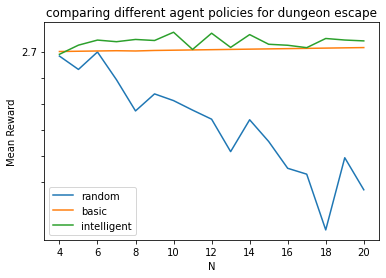

In [144]:
import matplotlib.pyplot as plt

plt.plot(number,mean_reward_tot[0], label = 'random')
plt.show
plt.plot(number,mean_reward_tot[1], label = 'basic')
plt.show
plt.plot(number,mean_reward_tot[2], label = 'intelligent')
plt.show
plt.legend()
plt.xlabel('N')
plt.ylabel('Mean Reward')
plt.yticks(np.arange(-500, 50, step=100))
plt.title('comparing different agent policies for dungeon escape')
#Drops are where the agent becomes trapped in obstacles (can't move) 